In [1]:
!pip install catboost phik shap boruta -q

In [2]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score #, mean_squared_error

import phik
from phik.report import plot_correlation_matrix
from phik import report
import shap
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import seaborn as sns
sns.set_theme()  # Тут можно задать стили

# <center>⚡️🏁 Quick start - тестируем простое решение</center>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
RANDOM_SEED = 777

## Анализируем данные о машинах car_info

🚗 Главное описание машин с информацией о поломках для обучения / прогноза - `car_train.csv` / `car_test.csv`.

**Пояснение столбцов:**
- `car_id` - идентификатор машины
- `model` / `car_type` / `fuel_type`- марка, класс и тип топлива машины
- `car_rating` / `riders` - общий рейтинг  и общее число поездок к концу 2021-го кода.
- `year_to_start` / `year_to_work` - года выпуска машины и начала работы в автопарке
- `main_city` - город пребывания машины. (Москва или Питер)
- `target_reg` - количество дней до поломки.
- `target_class` - класс поломки (всего 9 видов)

(2337, 10)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
484,a-2094929a,Audi Q3,premium,petrol,5.30,2013,41847,2022,19677.24,engine_ignition
290,N21846215c,Mini Cooper,business,petrol,4.46,2015,80359,2019,26970.25,engine_ignition
2195,x-8099343c,Renault Sandero,standart,petrol,2.22,2011,440,2018,5730.79,gear_stick
991,R-2878244Q,Renault Kaptur,standart,petrol,6.04,2013,51617,2016,1671.83,break_bug
547,a-2231592K,Kia Rio X,economy,petrol,5.88,2012,20475,2017,2678.18,another_bug


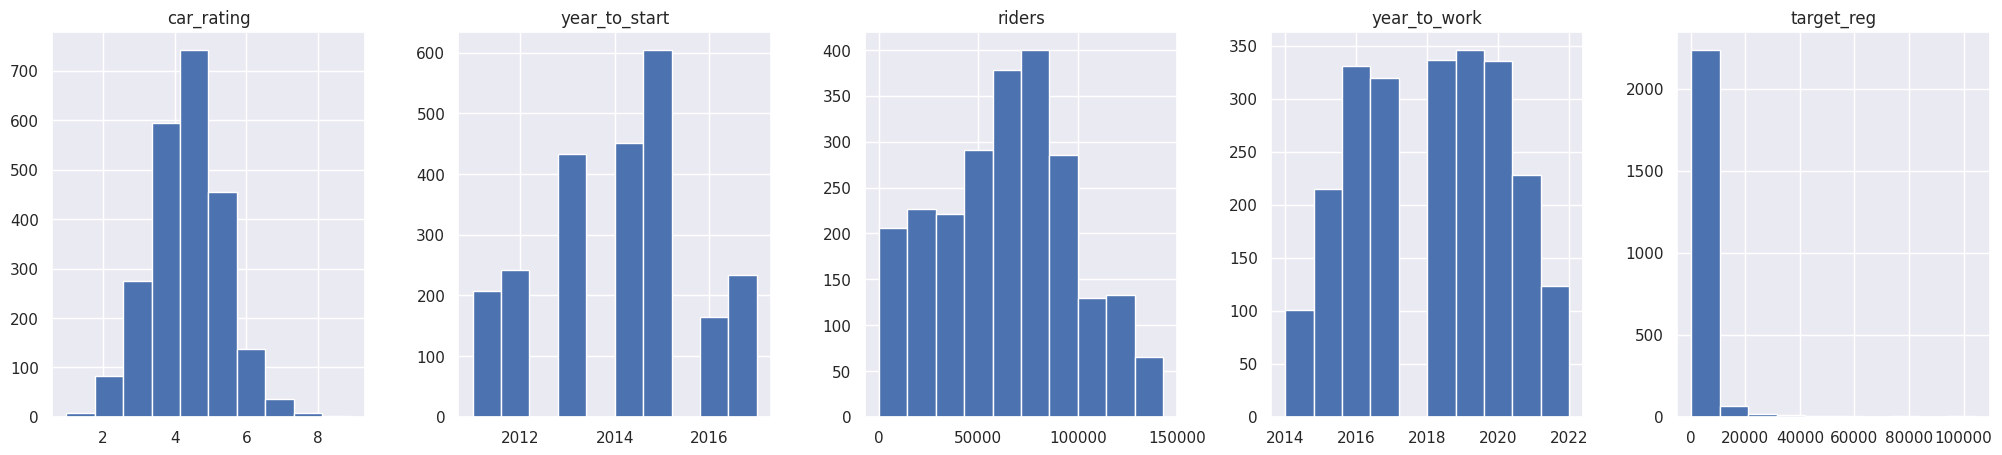

In [5]:
path = '/content/drive/MyDrive/Dimon/Песочница/ML_base/data/car_train.csv'
train = pd.read_csv(path)
print(train.shape)
train.hist(figsize=(25, 5), layout = (-1, 5))
train.sample(5)

In [6]:
path = '/content/drive/MyDrive/Dimon/Песочница/ML_base/data/car_test.csv'
test = pd.read_csv(path)
print(test.shape)
test.sample(5)

(1913, 8)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
796,r-3626163O,Skoda Rapid,economy,petrol,4.86,2015,84269,2016
865,O-2089662s,Nissan Qashqai,standart,petrol,5.04,2011,146,2018
441,q-1419523q,Renault Sandero,standart,petrol,4.72,2013,37048,2019
1826,f-1963567i,VW Polo,economy,petrol,4.22,2011,3323,2018
1277,b20875811r,Mercedes-Benz GLC,business,petrol,5.22,2013,41819,2016


## Классифицируем признаки на типы

In [7]:
features2drop = ['car_id']
targets = ['target_class', 'target_reg']
cat_features = ['car_type', 'fuel_type', 'model']

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

cat_features : 3 ['car_type', 'fuel_type', 'model']
num_features : 4 ['car_rating', 'year_to_start', 'riders', 'year_to_work']
targets ['target_class', 'target_reg']


## Обучаем Catboost и делаем прогноз на тест

In [8]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=cat_features, n_estimators = 100)


clf.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose=150, plot=False)

# инференс модели
y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

Learning rate set to 0.263488
0:	learn: 2.1785390	test: 2.1943955	best: 2.1943955 (0)	total: 162ms	remaining: 16.1s
99:	learn: 1.4720249	test: 2.3118861	best: 2.1851470 (5)	total: 12s	remaining: 0us

bestTest = 2.185146963
bestIteration = 5

Shrink model to first 6 iterations.

 Accuracy: 0.11324786324786325


In [9]:
test['target_class'] = clf.predict(test[filtered_features])
test[['car_id', 'target_class']].to_csv('simple_baseline_v1.csv', index=False)
print('CSV file saved!')

CSV file saved!


## Добавим информацию про поездки из rides_info


🏇 Информация про поездки - `rides_info.csv`.  **Пояснение столбцов:**
- `user_id` / `car_id` / `ride_id` - идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` - дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` -  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` - средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` - количество остановок (паузы) и флаг - была ли дозаправка.
- `user_ride_quality` - оценка манеры вождения в машины водителя, определенная скоринговой ML системой сервиса.
- `deviation_normal` - общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы).


In [10]:
path = '/content/drive/MyDrive/Dimon/Песочница/ML_base/data/rides_info.csv'
rides = pd.read_csv(path)
rides.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
720255,m18161938m,y21647488o,S1U,2020-02-06,4.94,35,274,55,71.141458,0,1.932246e+03,0,3.823631,12.488
329041,M18848812q,X11944438J,h1J,2020-01-05,2.07,25797,361154,51,60.000000,0,1.338394e+06,0,-6.614136,3.450
610871,i53588533C,r-3744124X,l1j,2020-03-10,5.41,9,113,44,65.953573,0,3.707361e+02,0,5.797341,24.755
13657,f48275857L,A56074965v,q1B,2020-02-14,2.89,37,365,45,83.000000,0,1.514410e+03,0,7.767594,34.720
23601,j53342367b,B15081492o,g1l,2020-02-28,5.48,8,59,60,68.086757,6,2.642081e+02,0,-1.633385,1.136


In [11]:
f = lambda x: x.nunique()
rides_df_gr = rides.groupby('car_id', as_index=False).agg(mean_rating = ('rating', 'mean'),
                                                   distance_sum = ('distance', 'sum'),
                                                   rating_min = ('rating', 'min'),
                                                   speed_max = ('speed_max', 'max'),
                                                   user_ride_quality_median = ('user_ride_quality', 'median'),
                                                   deviation_normal_count = ('deviation_normal', 'count'),
                                                   user_uniq = ('user_id', f))


rides_df_gr.head(2)

,car_id,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,A-1049127W,4.255172,1.125753e+07,0.1,179.729652,-0.288229,174,172
1,A-1079539w,4.088046,1.912765e+07,0.1,184.505566,2.508746,174,173


In [12]:
def add_featues(df):

    if 'mean_rating' not in df.columns:
        return df.merge(rides_df_gr, on = 'car_id', how = 'left')

    return df


train = add_featues(train)
test = add_featues(test)

In [13]:
train.sample(2)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
1045,L-4359316J,Smart ForFour,economy,petrol,4.98,2017,119893,2017,2003.50,engine_fuel,4.031322,1.644153e+07,0.1,179.070330,9.414614,174,173
295,E51339321G,Smart Coupe,economy,petrol,3.64,2013,44794,2021,12075.77,another_bug,4.903391,1.546566e+07,0.1,197.064209,1.919363,174,170


In [14]:
train.to_csv('quickstart_train.csv', index=False)

## Снова обновляем типы фичей

In [15]:
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print('num_features :', len(num_features), num_features)
print('cat_features :', len(cat_features), cat_features)
print('targets', targets)

num_features : 11 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq']
cat_features : 3 ['car_type', 'fuel_type', 'model']
targets ['target_class', 'target_reg']


## Обучаем Catboost на новых данных и делаем новый прогноз

In [16]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=cat_features, n_estimators = 150)


clf.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose=150, plot=False)

# инференс модели
y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

Learning rate set to 0.22568
0:	learn: 1.6212387	test: 1.6497106	best: 1.6497106 (0)	total: 105ms	remaining: 15.6s
149:	learn: 0.2063057	test: 0.5608913	best: 0.5499245 (65)	total: 27.6s	remaining: 0us

bestTest = 0.5499244647
bestIteration = 65

Shrink model to first 66 iterations.

 Accuracy: 0.7948717948717948


In [17]:
fi = clf.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,speed_max,37.047152
1,mean_rating,32.232507
2,rating_min,15.861294
3,user_uniq,3.280420
4,car_type,3.191561
5,user_ride_quality_median,1.989592
6,car_rating,1.735900
7,riders,1.708250
8,distance_sum,1.489515
9,year_to_work,1.170172


In [18]:
test['target_class'] = clf.predict(test[filtered_features])
test[['car_id', 'target_class']].to_csv('simple_baseline_v2.csv', index=False)
print('CSV file saved!')

CSV file saved!


# My_work

### Обработка данных

In [19]:
train.model.value_counts()

Hyundai Solaris       161
Smart ForFour         158
Renault Kaptur        154
Renault Sandero       152
VW Polo VI            152
Skoda Rapid           147
Kia Sportage          147
Nissan Qashqai        146
Kia Rio X             143
VW Polo               141
Kia Rio X-line        140
VW Tiguan             135
Smart ForTwo          130
Smart Coupe           118
Kia Rio               111
Mercedes-Benz E200     23
Mini Cooper            22
Audi Q3                21
MINI CooperSE          21
Audi A4                20
Fiat 500               18
Mercedes-Benz GLC      17
Audi A3                17
BMW 320i               16
Tesla Model 3          14
Volkswagen ID.4        13
Name: model, dtype: int64

In [20]:
X_lgb = X.copy()

le = LabelEncoder()
for col in cat_features:
    X_lgb[col] = le.fit_transform(X[col])

## Feature engineering + Visualization

In [21]:
# Загружаем уже знакомый нам датасет

rides_infol = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv")
cars = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv")
driver_info = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv")

rides_info = rides_infol.merge(cars, on="car_id", how="right")
rides_info = rides_info.merge(driver_info, on="user_id", how="left")
#----
rides_df_gr = rides_info.groupby('car_id', as_index=False).agg(mean_rating = ('rating', 'mean'),
                                                   distance_sum = ('distance', 'sum'),
                                                   rating_min = ('rating', 'min'),
                                                   speed_max = ('speed_max', 'max'),
                                                   user_ride_quality_median = ('user_ride_quality', 'median'),
                                                   deviation_normal_count = ('deviation_normal', 'count'),
                                                   user_uniq = ('user_id', f))
train = cars.merge(rides_df_gr, on = 'car_id', how = 'left')

In [22]:
cars.riders.isnull().any()

False

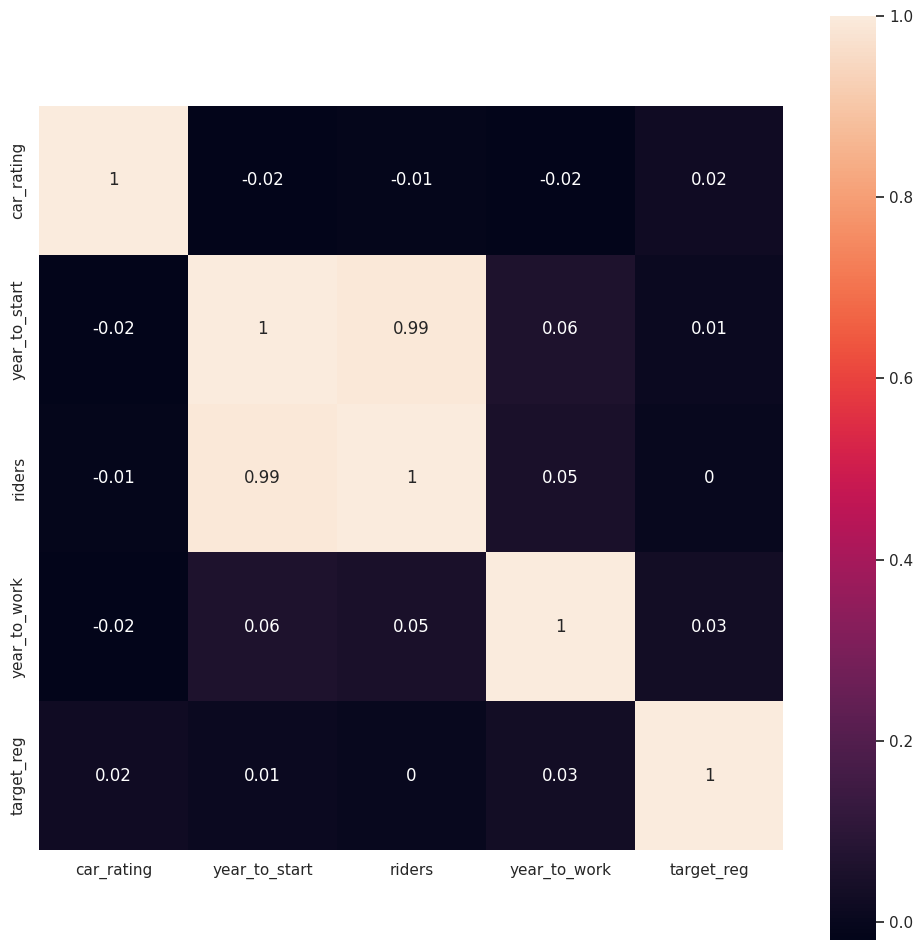

In [23]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 12)
sns.heatmap(
    data=cars.corr(numeric_only=True).round(2),
    square=True,
    annot=True,
);

### Visualiation

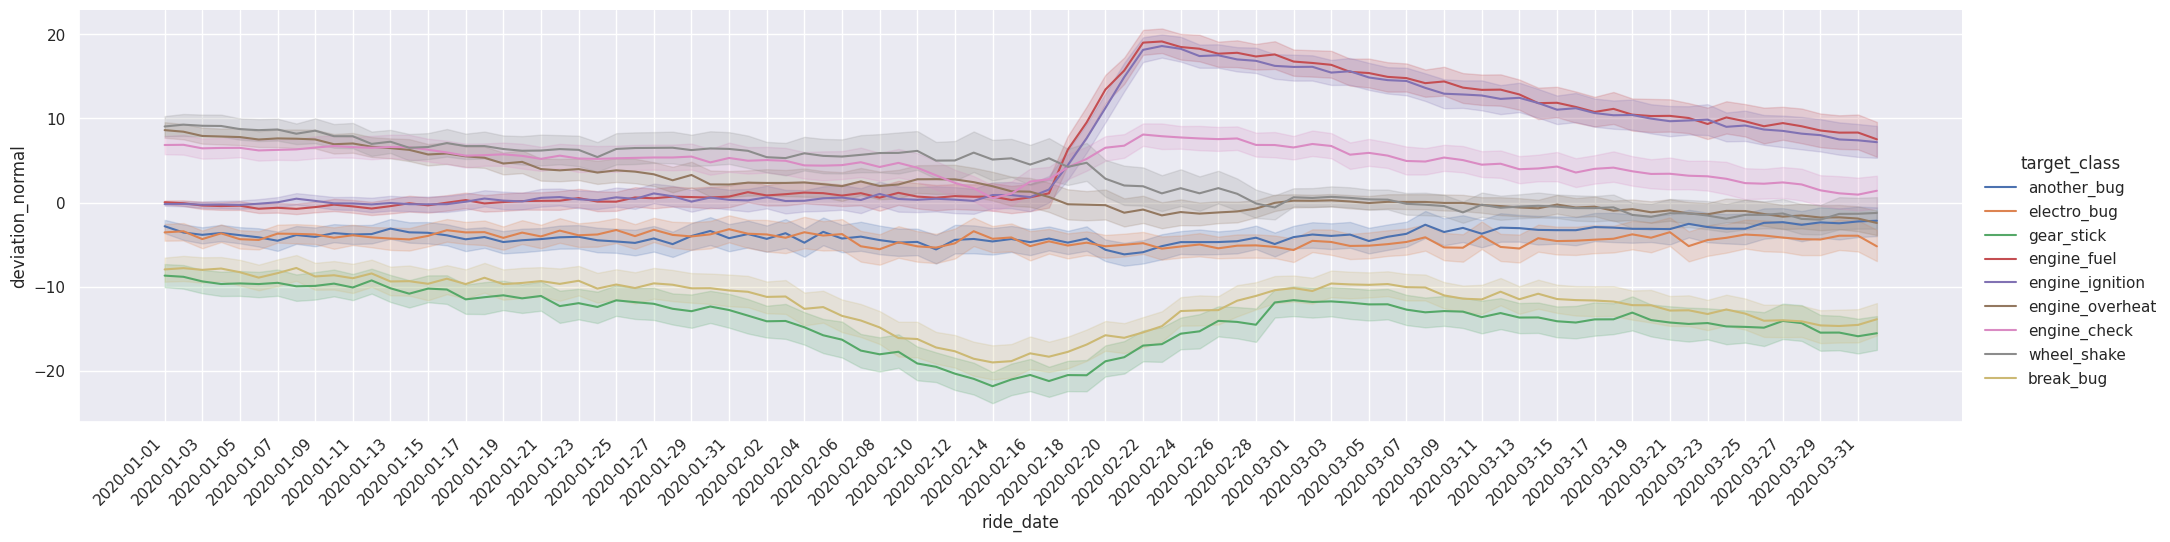

In [24]:
sns.set(rc={'figure.figsize':(18,12)})
g = sns.relplot(
    data=rides_info,
    x="ride_date",
    y="deviation_normal",
    hue="target_class",
    kind="line",  # или scatter
    aspect=4,
)

g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

Виден скачок для engine_fuel

In [25]:
# Создадим новый столбец, разбив данные на квантили
rides_info['ride_duration_quantile'] = pd.qcut(rides_info['ride_duration'], q=20, labels=[f'Quantile_{i+1}' for i in range(20)])

In [26]:
rides_info.ride_duration_quantile.min()

'Quantile_1'

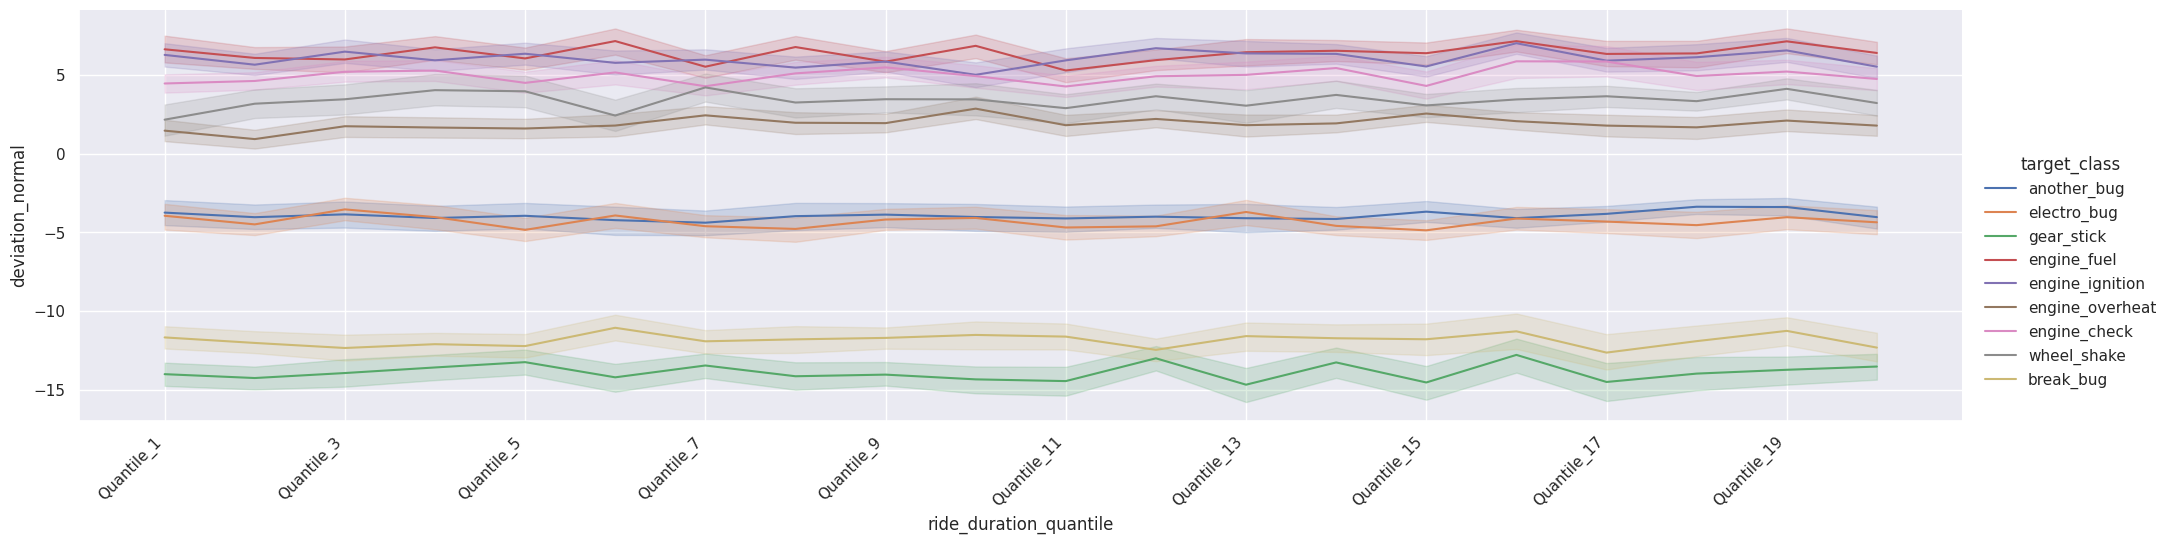

In [27]:
g = sns.relplot(
    data=rides_info,
    x="ride_duration_quantile",
    y="deviation_normal",
    hue="target_class",
    kind="line",  # или scatter
    aspect=4,
)

g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

Creating legend with loc="best" can be slow with large amounts of data.


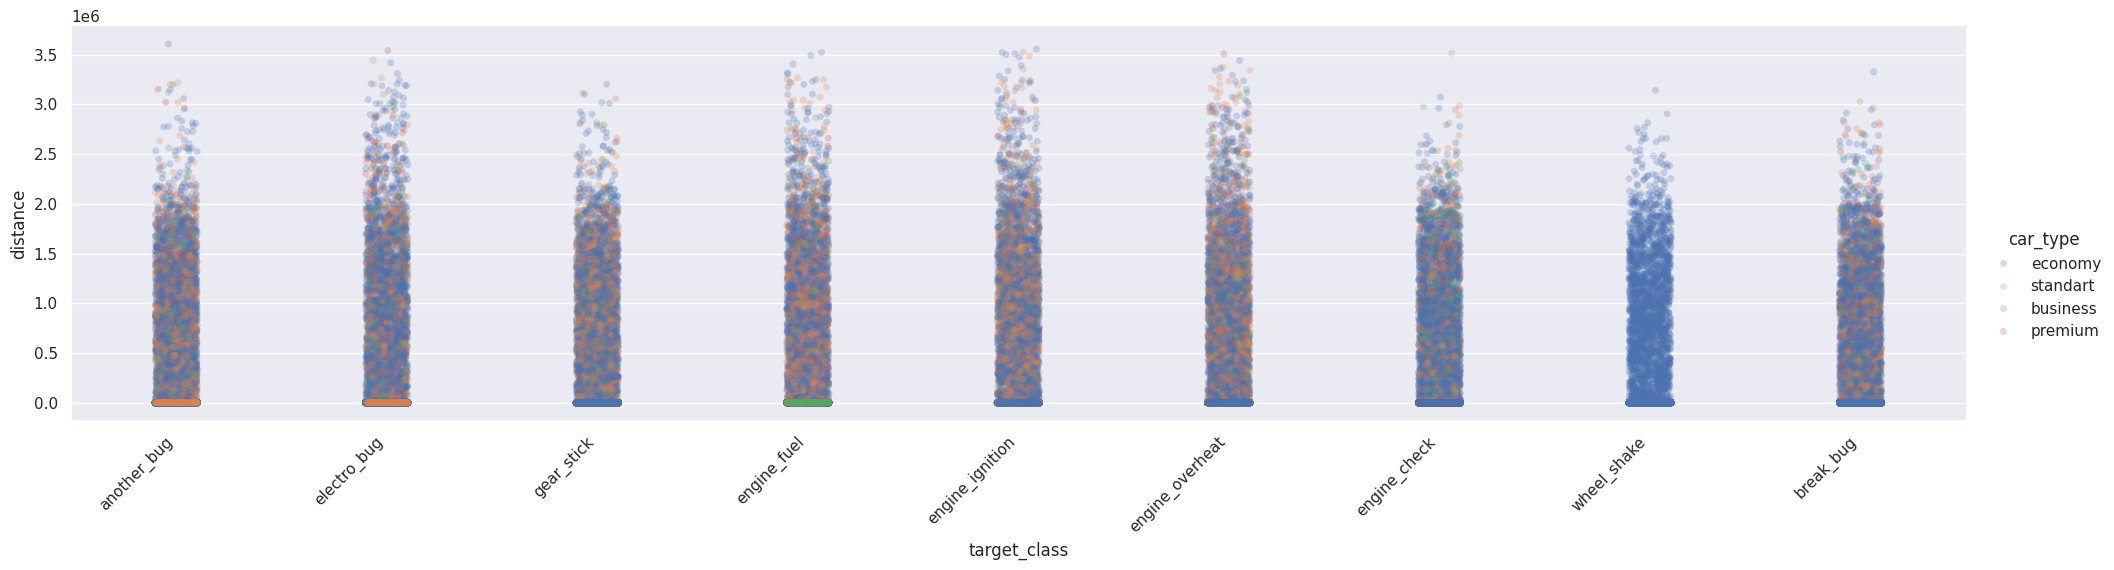

In [28]:
sns.catplot(
    data=rides_info,
    x="target_class",
    y="distance",

    aspect=4,
    hue="car_type",
    alpha=0.25,
    kind='strip',

).set_xticklabels(rotation=45, horizontalalignment="right");

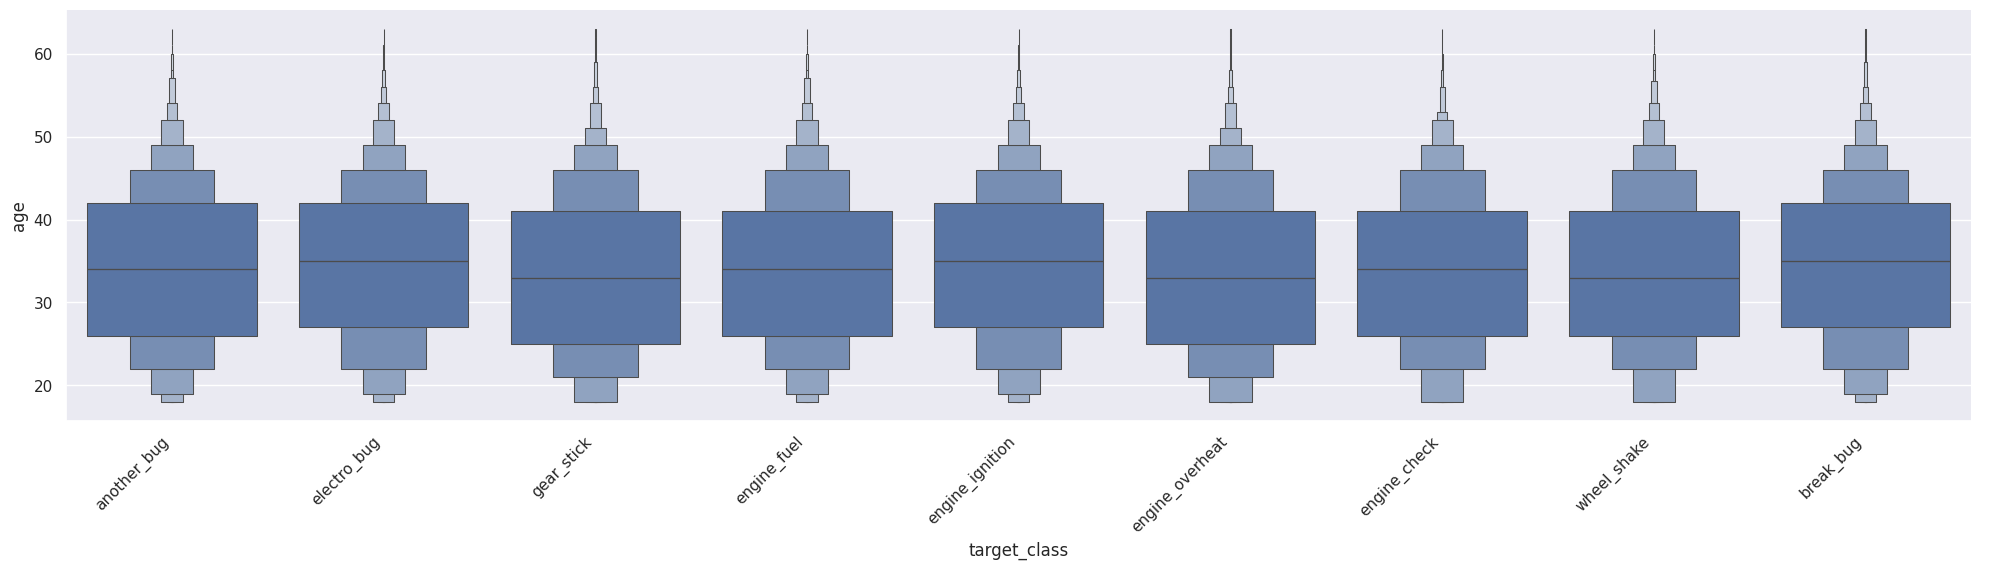

In [29]:
# Варируем в параметр kind, получаем любой вид графики

sns.catplot(
    data=rides_info,
    x="target_class",
    y="age",
    # hue="car_type",
    aspect=4,
    kind="boxen",
).set_xticklabels(rotation=45, horizontalalignment="right");

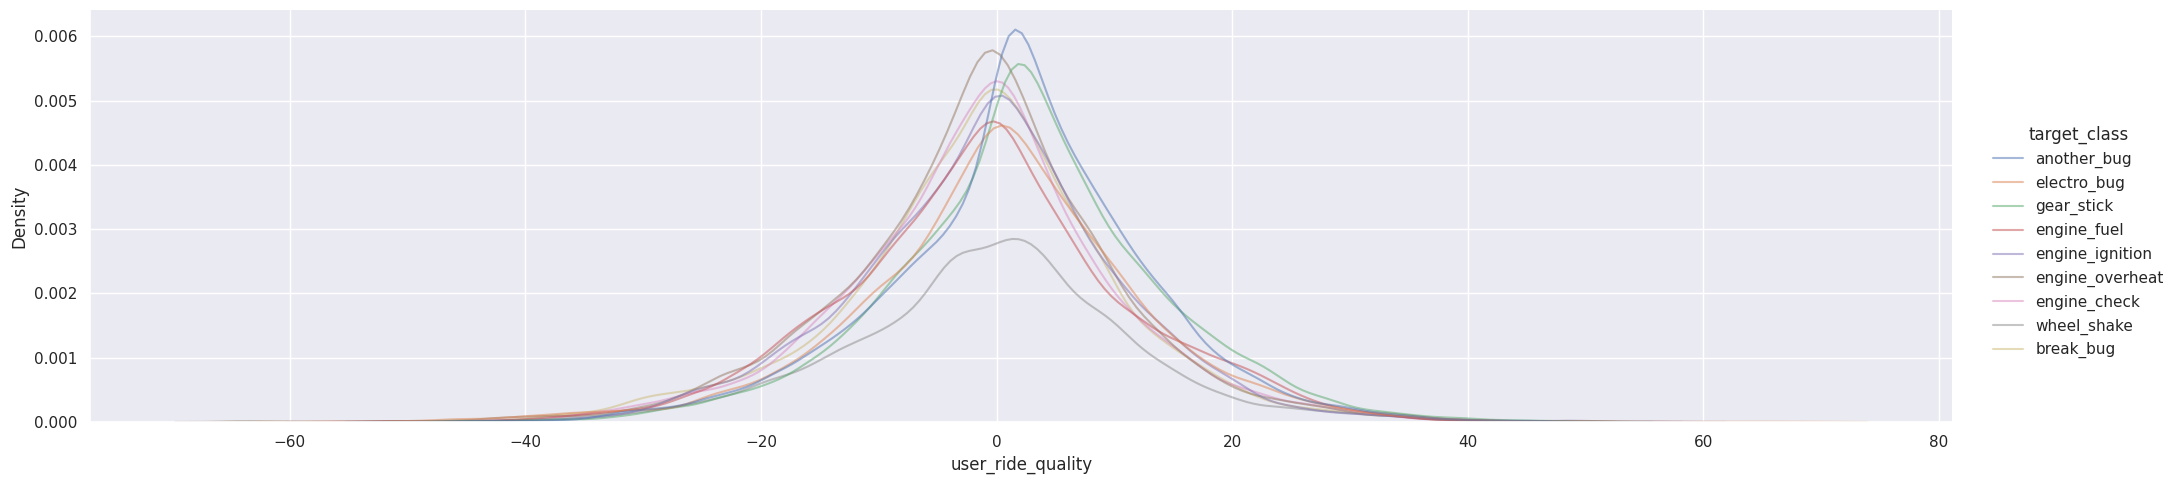

In [30]:
g = sns.displot(
    data=rides_info,

    x="user_ride_quality",
    # y="user_time_accident",

    hue="target_class",
    legend=True,
    aspect=4,
    kind="kde", # hist
    alpha=0.5,
);

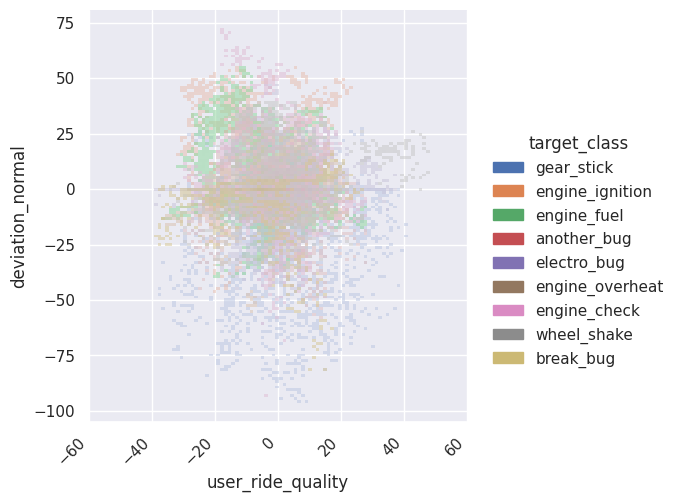

In [31]:
tmp = rides_info[rides_info["car_id"].isin(rides_info.sample(200, random_state=10).car_id.unique()[:100])]
g = sns.displot(
    data=tmp,

    x="user_ride_quality",
    y="deviation_normal",

    aspect=1,
    # kind="kde",
    alpha=0.5,

    hue="target_class",
    # col="target_class",

).set_xticklabels(rotation=45, horizontalalignment="right");

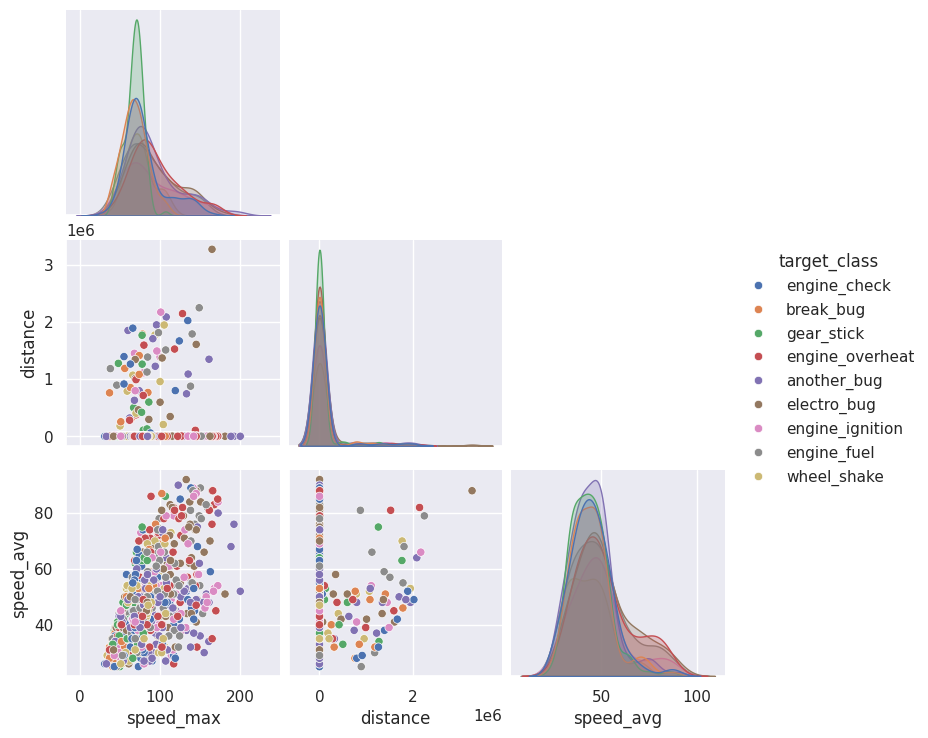

In [32]:
sns.pairplot(
    rides_info.sample(1000),
    vars=["speed_max", "distance", "speed_avg"],
    corner=True,
    hue="target_class",
);

### Feature engineering

In [33]:
train.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,3.880920,1.651883e+07,0.1,172.793237,-5.029476,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,4.181149,1.398317e+07,0.1,203.462289,-14.260456,174,171


In [34]:
def f1(x):
  ma = max([x.iloc[i+1]-x.iloc[i] for i in range(len(x)-1)])
  if ma < 5:
    return 0
  else:
    return ma

def f2(x):
  li = [x.iloc[i+1]-x.iloc[i] for i in range(len(x)-1)]
  max_li = max(li)
  if max_li < 1:
     return 0
  else:
     ind = li.index(max_li)
     return ind+1


result = rides_infol.groupby('car_id').agg(
    gold_feature_1=("deviation_normal", f1),
    gold_feature_2=('deviation_normal', f2))
result['car_id'] = result.index
result.reset_index(drop=True, inplace=True)

my_train = train.merge(result, on="car_id", how="left")
my_test = test.merge(result, on="car_id", how="left")

In [35]:
def baseline(df, test, features2drop, targets, cat_features):
  filtered_features = [i for i in df.columns if (i not in targets and i not in features2drop)]
  num_features = [i for i in filtered_features if i not in cat_features]

  X = df[filtered_features].drop(targets, axis=1, errors='ignore')
  y = df['target_class']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  clf = CatBoostClassifier(cat_features=cat_features, n_estimators = 100)


  clf.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose=150, plot=False)

  # инференс модели
  y_pred = clf.predict(X_test)
  print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

  test['target_class'] = clf.predict(test[filtered_features])
  test[['car_id', 'target_class']].to_csv('simple_baseline_v1.csv', index=False)
  print('CSV file saved!')
  return clf

In [36]:
features2drop = ['car_id']
targets = ['target_class', 'target_reg']
cat_features = ['car_type', 'fuel_type', 'model']

In [37]:
baseline_model = baseline(train, test, features2drop, targets, cat_features)

Learning rate set to 0.263488
0:	learn: 1.5427912	test: 1.5761045	best: 1.5761045 (0)	total: 43.4ms	remaining: 4.3s
99:	learn: 0.2523081	test: 0.5733990	best: 0.5473633 (58)	total: 5.87s	remaining: 0us

bestTest = 0.5473633365
bestIteration = 58

Shrink model to first 59 iterations.

 Accuracy: 0.7841880341880342
CSV file saved!


In [38]:
baseline_model_2 = baseline(my_train, my_test, features2drop, targets, cat_features)

Learning rate set to 0.263488
0:	learn: 1.4589469	test: 1.4774986	best: 1.4774986 (0)	total: 50ms	remaining: 4.95s
99:	learn: 0.1518494	test: 0.3967727	best: 0.3967727 (99)	total: 5.38s	remaining: 0us

bestTest = 0.3967727358
bestIteration = 99


 Accuracy: 0.8739316239316239
CSV file saved!


++ 0.1 на лидерборде

## Validation

**StratifiedKFold**

In [39]:
from sklearn.model_selection import StratifiedKFold

N = 10

# Создаем бины, иначе стратификатор не сработает
my_train['target_reg_group'] = pd.qcut(my_train['target_reg'], N, labels = [f'group_{i}' for i in range(N)])

# Создаем итератор для фолдов
skf = StratifiedKFold(n_splits=N, shuffle = True)
y = my_train['target_reg_group']
my_train['num_fold'] = None

# Запускаем итератор, указав группы таргета для стратификации
for i, (train_index, test_index) in enumerate(skf.split(my_train, my_train['target_reg_group'])):
    my_train.loc[test_index, 'num_fold'] = i

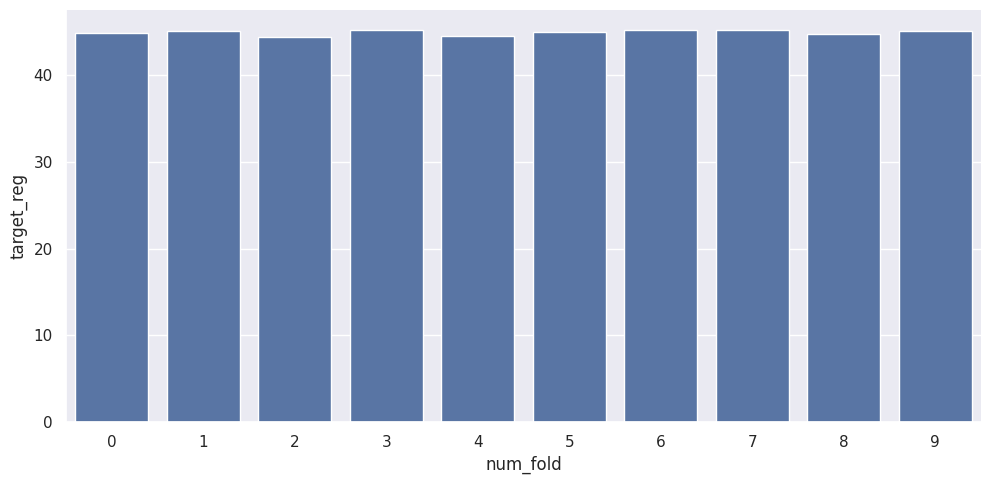

In [40]:
import seaborn as sns

tmp = my_train.groupby('num_fold', as_index=False)['target_reg'].agg('mean')
sns.catplot(data = tmp, x = 'num_fold', y = 'target_reg', aspect=2, kind="bar");

**KFold**

In [41]:
# Инициализируем k-fold кросс-валидацию
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
X = my_train[filtered_features].drop(targets, axis=1, errors='ignore')
y = my_train['target_class']
# Проходим по фолдам
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}:")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Здесь вы можете обучать модель на X_train, y_train и оценивать ее на X_test, y_test
    # Например, используя ваш алгоритм машинного обучения

    print(X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0])

Fold 1:
1869 468 1869 468
Fold 2:
1869 468 1869 468
Fold 3:
1870 467 1870 467
Fold 4:
1870 467 1870 467
Fold 5:
1870 467 1870 467


**train_test_split**

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0])

1869 468 1869 468


**Baseline_2**

In [43]:
my_train

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq,gold_feature_1,gold_feature_2,target_reg_group,num_fold
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,1.214131e+07,0.10,180.855726,0.023174,174,170,9.000,128,group_9,9
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,1.803909e+07,0.00,187.862734,12.306011,174,174,29.279,67,group_3,6
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,1.588366e+07,0.10,102.382857,2.513319,174,173,11.000,53,group_4,7
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,1.651883e+07,0.10,172.793237,-5.029476,174,170,18.047,91,group_1,5
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,1.398317e+07,0.10,203.462289,-14.260456,174,171,14.131,95,group_2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,...,1.739222e+07,0.10,141.502350,-6.624534,174,171,9.922,17,group_0,8
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,...,1.174052e+07,0.10,155.000000,-8.582467,174,169,40.017,96,group_9,8
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,...,1.202022e+07,0.10,104.180940,-0.778524,174,172,22.011,162,group_6,9
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,...,1.788307e+07,0.10,200.000000,2.464975,174,171,28.781,151,group_9,8


In [44]:
def baseline_kf(df, test, features2drop, targets, cat_features):
  filtered_features = [i for i in df.columns if (i not in targets and i not in features2drop)]
  num_features = [i for i in filtered_features if i not in cat_features]

  X = df[filtered_features].drop(targets, axis=1, errors='ignore')
  y = df['target_class']
  kf = KFold(n_splits=5, shuffle=True, random_state=5)
  all_res = []
  all_models = []
  for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index],  y.iloc[test_index]
    clf = CatBoostClassifier(cat_features=cat_features, n_estimators = 100)


    clf.fit(X_train, y_train,
          eval_set=(X_test, y_test),
            plot=False, verbose=False)

    # инференс модели
    y_pred = clf.predict(X_test)
    all_res.append(accuracy_score(y_test, y_pred))
    all_models.append(clf)
    print(f"Fold {fold+1}")
  print(f'\n mean Accuracy: {accuracy_score(y_test, y_pred)}')
  test['target_class'] = clf.predict(test[filtered_features])
  test[['car_id', 'target_class']].to_csv('simple_baseline_v1.csv', index=False)
  print('CSV file saved!')
  return all_models

In [45]:
faulty loss function(not likely when using built-in funcitons)baseline_model_kf = baseline_kf(my_train, my_test, features2drop, targets, cat_features)

SyntaxError: invalid syntax (<ipython-input-45-42a959eb56c9>, line 1)

In [ ]:
len(baseline_model_kf)

## Фильтрация признаков

In [ ]:
phik_overview = my_train.phik_matrix().round(2).sort_values('target_reg')

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

**Feature_importance**

In [ ]:
baseline_model.get_feature_importance(prettified=True)

**Permutation Importance**

In [ ]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(baseline_model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

**SHAP** **values**

In [ ]:
# Посмотрим на SHAP values
explainer = shap.TreeExplainer(baseline_model)

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display = 25)

**BorutaPy**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(cat_features, axis=1), y, test_size=0.2, random_state=42)
print(X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0])

In [ ]:
###initialize Boruta
forest = RandomForestClassifier(
   n_jobs = -1,
   max_depth = 3
)
boruta = BorutaPy(
   estimator = forest,
   n_estimators = 'auto',
   max_iter = 8, # number of trials to perform
    verbose=1
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X_train), np.array(y_train))
### print results
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
red_area = X_train.columns[~(boruta.support_ | boruta.support_weak_)].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)
print('features in the red area:', red_area)

In [ ]:
beee = ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'deviation_normal_count']
model = baseline(my_train, my_test, features2drop+beee, targets, cat_features)

## Визуализация работы модели

In [ ]:
model = baseline(my_train, my_test, features2drop, targets, cat_features)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0])

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=clf.classes_))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, xticks_rotation = 45)

Визуализация True и Predict

In [ ]:
cbr_prediction = regr.predict(X_test)

df_pred = pd.DataFrame(cbr_prediction, columns = ["Predicted_values"])
df_pred["Actual_values"] =  y_test.values

g = sns.relplot(data = df_pred, aspect = 4, kind = 'line')
# g.set(yscale="log")#.set(xscale="log")

## **Models Regression**

In [46]:
my_train.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq,gold_feature_1,gold_feature_2,target_reg_group,num_fold
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,1.214131e+07,0.1,180.855726,0.023174,174,170,9.000,128,group_9,9
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,1.803909e+07,0.0,187.862734,12.306011,174,174,29.279,67,group_3,6
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,1.588366e+07,0.1,102.382857,2.513319,174,173,11.000,53,group_4,7
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,1.651883e+07,0.1,172.793237,-5.029476,174,170,18.047,91,group_1,5
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,1.398317e+07,0.1,203.462289,-14.260456,174,171,14.131,95,group_2,5


In [47]:
cat_features += ['target_reg_group', 'num_fold']

In [48]:
X = my_train.drop(['target_reg', 'target_class', 'car_id'], axis=1)
y = my_train['target_reg']
X_lgb = X.copy()

le = LabelEncoder()
for col in cat_features+['target_reg_group']:
    X_lgb[col] = le.fit_transform(X[col])
X_train, X_test, y_train, y_test = train_test_split(X_lgb, y, test_size=0.2, random_state=42)

In [49]:

from sklearn.metrics import mean_squared_error as mse

### Liner Regression

In [50]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression(
    n_jobs = -1,
).fit(X_train, y_train)
predicts = reg.predict(X_test)
print("MSE score = ", mse(y_test, predicts))

MSE score =  48.94131942127735


In [51]:
df = pd.DataFrame({'coef': reg.coef_, 'name': X_train.columns})
sorted_df = df.sort_values(by='coef')
sorted_df.head()

,coef,name
2,-4.939440,fuel_type
13,-0.297319,user_uniq
4,-0.271028,year_to_start
0,-0.022605,model
15,-0.004170,gold_feature_2


### SVR

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))  # без StandardScaler = 350
regr.fit(X_train, y_train)
predict = regr.predict(X_test)
print("MSE score = ", mse(y_test, predict))

MSE score =  88.91270023123484


In [53]:
regr.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()), ('svr', SVR(epsilon=0.2))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'svr': SVR(epsilon=0.2),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'svr__C': 1.0,
 'svr__cache_size': 200,
 'svr__coef0': 0.0,
 'svr__degree': 3,
 'svr__epsilon': 0.2,
 'svr__gamma': 'scale',
 'svr__kernel': 'rbf',
 'svr__max_iter': -1,
 'svr__shrinking': True,
 'svr__tol': 0.001,
 'svr__verbose': False}

### RFR

In [54]:
from sklearn.ensemble import RandomForestRegressor as rfr

regr = rfr(max_depth=6,
           random_state=0,
           n_estimators = 100,
           )
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
print("MSE score = ", mse(y_test, pred))

MSE score =  20.589492748589365


### DTR

In [55]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

regressor = DecisionTreeRegressor(random_state=0, max_depth=5, min_samples_split=2)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print("MSE score = ", mse(y_test, y_pred))


MSE score =  22.048120743116606


### **XGboost**

In [56]:
import xgboost as xgb

# Подготовка данных
X = my_train.drop(['target_reg', 'target_class', 'car_id'], axis=1)
y = my_train['target_reg']

# Изменяем тип категориальных фичей так, что XGBoost всё устроило
for col in cat_features:
    X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
params = {
    'booster': 'dart',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'verbosity': 0,
    'nthread': -1,
    'seed': 777,
}

# Добавим Scheduler
iters = 15
learning_rates = np.linspace(0.3, 0.005, iters).tolist()
scheduler = xgb.callback.LearningRateScheduler(learning_rates)

train_dataset = xgb.DMatrix(
    data=X_train,
    label=y_train,
    nthread=-1,
    enable_categorical=True,
)

eval_dataset = xgb.DMatrix(
    data=X_test,
    label=y_test,
    nthread=-1,
    enable_categorical=True,
)

model = xgb.train(
    params,
    dtrain=train_dataset,
    evals=[(train_dataset, 'train'), (eval_dataset, 'val')],
    num_boost_round=iters,
    callbacks=[scheduler],
    verbose_eval=0,
)

preds = model.predict(eval_dataset, iteration_range=(0, iters))
print("MSE score = ", mse(y_test, preds))

MSE score =  25.72875883780614


### **CatBoost**

In [58]:
# Object importance
X_train = X_train.reset_index(drop=True)
train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
randomized_search_result = {'l2_leaf_reg': 5,
 'subsample': 0.8775056753965695,
 'rsm': 0.5615030923984693,
 'depth': 3.0,
 'one_hot_max_size': 3.0,
 'learning_rate': 0.03}
model = CatBoostRegressor(
    iterations=3000,
    eval_metric='RMSE',
    thread_count=-1,
    random_seed=RANDOM_SEED,
    **randomized_search_result
)

model.fit(
    train_dataset,
    eval_set=eval_dataset,
    early_stopping_rounds=50,
    verbose=False,
    use_best_model=True,
)

idxs, scores = model.get_object_importance(
    eval_dataset,
    train_dataset,
    importance_values_sign="Positive",
    thread_count=-1,
)
preds = model.predict(eval_dataset)
print("MSE score = ", mse(y_test, preds))

MSE score =  28.612831723979596


### **LightGBM**

In [59]:
import lightgbm as lgb

# Подготовка данных
X = my_train.drop(['target_reg', 'target_class', 'car_id'], axis=1)
y = my_train['target_reg']

# Изменяем тип категориальных фичей так, что LightGBM всё устроило
label_encoder = LabelEncoder()
for col in cat_features:
    X[col] = label_encoder.fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
params = {
    'boosting_type': 'goss',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'early_stopping_rounds': 50,
    'seed': RANDOM_SEED,
    'verbose': -1,
}

train_dataset = lgb.Dataset(
    data=X_train,
    label=y_train,
    categorical_feature=cat_features,
)

eval_dataset = lgb.Dataset(
    data=X_test,
    label=y_test,
    categorical_feature=cat_features,
)

model = lgb.train(
    params,
    train_set=train_dataset,
    valid_sets=(eval_dataset),
    num_boost_round=500,
)

print(model.best_score['valid_0']['rmse'])
pred = model.predict(X_test)
print('MSE =', mse(pred, y_test))


4.917033885611157
MSE = 24.1772209531422


### **KNN Regression**

In [61]:
from sklearn.neighbors import KNeighborsRegressor

for i in range(5, 15):
  neigh = KNeighborsRegressor(n_neighbors=i)
  neigh.fit(X_train, y_train)
  pred = neigh.predict(X_test)
  print(f"MSE ({i}) =", mse(pred, y_test))

MSE (5) = 393.02898688888894
MSE (6) = 376.6657655804844
MSE (7) = 368.36781386708526
MSE (8) = 358.55883368055555
MSE (9) = 357.60817854806373
MSE (10) = 349.93522882051286
MSE (11) = 350.12863131666313
MSE (12) = 349.75496678834287
MSE (13) = 348.96561173064276
MSE (14) = 347.70439785888715


### **Neural Networks**

In [ ]:
import torch
from torch.autograd import Variable

In [ ]:
X_train.shape

In [ ]:
for i in [X_train, X_test]:
  for j in i.columns:
    i[j] = i[j].astype('double')

In [ ]:
y_tensor_train = Variable(torch.from_numpy(y_train.to_numpy())) # changed the NumPy array to tensor format
y_tensor_test = Variable(torch.from_numpy(y_test.to_numpy())) # changed the NumPy array to tensor format
x_tensor_train = Variable(torch.from_numpy(X_train.to_numpy())) # changed the NumPy array to tensor format
x_tensor_test = Variable(torch.from_numpy(X_test.to_numpy())) # changed the NumPy array to tensor format

In [120]:
x_tensor_train.dtype

torch.float64

In [121]:
input_dim = 1

In [ ]:
# Import Libraries
from torch.autograd import Variable
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")

# create class
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        # super function. It inherits from nn.Module and we can access everythink in nn.Module
        super(LinearRegression, self).__init__()

        # linear function
        self.linear = nn.Linear(input_dim, output_dim)
        self.double() ##

    def forward(self, x_tensor):
        return self.linear(x_tensor)

# define model
input_dim = 18
output_dim = 1
model = LinearRegression(input_dim, output_dim)

# MSE
mse = nn.MSELoss()

# Optimization (find parameters that minimize error)
learning_rate = 0.00002 # how fast we reach best parameters
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# train model
loss_list = []
iteration_number = 1001
for iteration in range(iteration_number):

    # optimization
    optimizer.zero_grad()

    # forward to get output
    results = model(x_tensor_train)

    # Calculate loss
    loss = mse(results, y_tensor_train)

    # backward propagation
    loss.backward()

    # Updating parameters
    optimizer.step()

    # store loss
    loss_list.append(loss.data)

    # print loss
    if(iteration % 50 == 0):
        print('epoch {}, loss {}'.format(iteration, loss.data))

plt.plot(range(iteration_number),loss_list)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

epoch 0, loss 2202762959364.796
epoch 50, loss nan
epoch 100, loss nan
epoch 150, loss nan
epoch 200, loss nan
epoch 250, loss nan
epoch 300, loss nan
epoch 350, loss nan


## **Models Classification**

In [81]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

# Подготовка данных
X = my_train.drop(['target_reg', 'target_class', 'car_id'], axis=1)
y = my_train['target_class']

# Изменяем тип категориальных фичей так, что LightGBM всё устроило
label_encoder = LabelEncoder()
for col in cat_features:
    X[col] = label_encoder.fit_transform(X[col])
ley = LabelEncoder()
y = ley.fit_transform(y)
mapping = dict(zip(ley.classes_, range(len(ley.classes_))))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Logistic Regression**

In [82]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
pred = clf.predict(X_test)
pred_proba = clf.predict_proba(X_test)

In [85]:
from sklearn.metrics import classification_report

label_names = list([str(i) for i in range(9)])
print(classification_report(y_test, pred, target_names=label_names))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        58
           1       0.00      0.00      0.00        56
           2       0.00      0.00      0.00        51
           3       0.09      0.24      0.13        49
           4       0.00      0.00      0.00        58
           5       0.00      0.00      0.00        58
           6       0.09      0.54      0.16        48
           7       0.13      0.16      0.14        51
           8       0.00      0.00      0.00        39

    accuracy                           0.10       468
   macro avg       0.04      0.10      0.05       468
weighted avg       0.03      0.10      0.05       468



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


### **SVM**

In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score as acs

clf = svm.SVC(C=1.0)  # без StandardScaler = 350
clf.fit(X_train, y_train)
predict = clf.predict(X_test)
print("Accuracy score = ", acs(y_test, predict))

Accuracy score =  0.10897435897435898


### **GaussinaNB**

In [93]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Accuracy score = ", acs(y_test, y_pred))

Accuracy score =  0.17094017094017094


### **KNN Classification**

In [101]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)
y_pred = neigh.predict(X_test)
print("Accuracy score = ", acs(y_test, y_pred))

Accuracy score =  0.46794871794871795


### **DTC + RFC**

In [102]:
from sklearn.tree import DecisionTreeClassifier

regressor = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=2)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print("Accuracy score = ", acs(y_test, y_pred))

Accuracy score =  0.75


In [105]:
from sklearn.ensemble import RandomForestClassifier as rfc

regr = rfc(max_depth=6,
           random_state=0,
           n_estimators = 200,
           )
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print("Accuracy score = ", acs(y_test, y_pred))

Accuracy score =  0.9166666666666666


### **CatBoostClasifire**

In [116]:
# Object importance
X_train = X_train.reset_index(drop=True)
train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
randomized_search_result = {'subsample': 0.8775056753965695,
 'rsm': 0.5615030923984693,
 'depth': 3.0,
 'one_hot_max_size': 3.0,
 'learning_rate': 0.03}
model = CatBoostClassifier(
    iterations=300,
    eval_metric='Accuracy',
    thread_count=-1,
    random_seed=RANDOM_SEED,
    #**randomized_search_result
)

model.fit(
    train_dataset,
    eval_set=eval_dataset,
    early_stopping_rounds=50,
    verbose=20,
    use_best_model=True,
)

preds = model.predict(eval_dataset)
print("Accurancy score = ", acs(y_test, preds))

Learning rate set to 0.173181
0:	learn: 0.7089353	test: 0.6965812	best: 0.6965812 (0)	total: 133ms	remaining: 39.8s
20:	learn: 0.9117175	test: 0.9102564	best: 0.9102564 (18)	total: 4.88s	remaining: 1m 4s
40:	learn: 0.9357945	test: 0.9123932	best: 0.9123932 (21)	total: 9.74s	remaining: 1m 1s
60:	learn: 0.9529160	test: 0.9230769	best: 0.9230769 (58)	total: 13.8s	remaining: 54.1s
80:	learn: 0.9689674	test: 0.9273504	best: 0.9273504 (77)	total: 16.7s	remaining: 45s
100:	learn: 0.9732477	test: 0.9294872	best: 0.9316239 (90)	total: 20.3s	remaining: 40.1s
120:	learn: 0.9769930	test: 0.9273504	best: 0.9316239 (90)	total: 26.5s	remaining: 39.3s
140:	learn: 0.9828785	test: 0.9294872	best: 0.9316239 (90)	total: 29.7s	remaining: 33.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9316239316
bestIteration = 90

Shrink model to first 91 iterations.
Accurancy score =  0.9316239316239316


### **Neural Network**

## **Optuna**